In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType, DoubleType
import os 
import warnings
warnings.filterwarnings('ignore')
os.chdir('C:/Users/aditya/Desktop/New folder')

In [2]:
filna_path = 'C:/Users/aditya/Desktop/New folder/bank-full.csv'
target_variable_name = 'y'

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filna_path, header=True, inferSchema=True, sep=';')
df.show()

#convert target columns into numerical
df = df.withColumn('y', F.when(F.col("y") == 'yes',1).otherwise(0))

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [3]:
def variable_type(df):
    
    vars_list = df.dtypes
    char_vars = []
    num_vars = []
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])
    
    return char_vars, num_vars

char_vars, num_vars = variable_type(df)
num_vars.remove(target_variable_name)

def category_to_index(df, char_vars):
    
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

df, char_labels = category_to_index(df, char_vars)
df = df.select([c for c in df.columns if c not in char_vars])

def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([F.col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

df = rename_columns(df, char_vars)
df.show()

+---+-------+---+--------+--------+-----+--------+---+----+-------+---------+-------+-------+----+-------+-----+--------+
|age|balance|day|duration|campaign|pdays|previous|  y| job|marital|education|default|housing|loan|contact|month|poutcome|
+---+-------+---+--------+--------+-----+--------+---+----+-------+---------+-------+-------+----+-------+-----+--------+
| 58|   2143|  5|     261|       1|   -1|       0|  0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
| 44|     29|  5|     151|       1|   -1|       0|  0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
| 33|      2|  5|      76|       1|   -1|       0|  0| 7.0|    0.0|      0.0|    0.0|    0.0| 1.0|    1.0|  0.0|     0.0|
| 47|   1506|  5|      92|       1|   -1|       0|  0| 0.0|    0.0|      3.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
| 33|      1|  5|     198|       1|   -1|       0|  0|11.0|    1.0|      3.0|    0.0|    1.0| 0.0|    1.0|  0.0|     0.0|
| 35|    231|  5|     13

In [4]:
#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df, assembleModel, selectedCols

#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove(target_variable_name)

# apply the function on our dataframe
df, assembleModel, selectedCols = assemble_vectors(df, features_list, target_variable_name)

In [5]:
assembleModel

PipelineModel_e1cb85bc3dab

In [6]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)

In [7]:
train.count(), test.count()

(31559, 13652)

In [8]:
clf = RandomForestClassifier(featuresCol='features', labelCol='y')
clf_model = clf.fit(train)
print(clf_model.featureImportances)
print(clf_model.toDebugString)

(16,[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15],[0.06335941361841711,0.00630326130094528,0.019986486550451515,0.37236215665860395,0.006330563449685545,0.05727047985667547,0.06358138161963887,0.0039932406288470295,0.003172552121232565,0.001497466525589269,0.03808816690074513,0.005970068585899278,0.007432922274302237,0.06851222077854544,0.28213961913042135])
RandomForestClassificationModel: uid=RandomForestClassifier_b4fac0031551, numTrees=20, numClasses=2, numFeatures=16
  Tree 0 (weight 1.0):
    If (feature 6 <= 0.5)
     If (feature 0 <= 60.5)
      If (feature 14 in {7.0,8.0,9.0,10.0,11.0})
       If (feature 3 <= 219.5)
        Predict: 0.0
       Else (feature 3 > 219.5)
        If (feature 3 <= 675.5)
         Predict: 0.0
        Else (feature 3 > 675.5)
         Predict: 1.0
      Else (feature 14 not in {7.0,8.0,9.0,10.0,11.0})
       If (feature 13 in {1.0,2.0})
        Predict: 0.0
       Else (feature 13 not in {1.0,2.0})
        If (feature 3 <= 556.5)
         Predict: 0.0
     

In [9]:
train_pred_result = clf_model.transform(train)
test_pred_result = clf_model.transform(test)

In [10]:
def evaluation_metrics(df, target_variable_name):
    pred = df.select("prediction", target_variable_name)
    pred = pred.withColumn(target_variable_name, pred[target_variable_name].cast(DoubleType()))
    pred = pred.withColumn("prediction", pred["prediction"].cast(DoubleType()))
    metrics = MulticlassMetrics(pred.rdd.map(tuple))
    # confusion matrix
    cm = metrics.confusionMatrix().toArray()
    acc = metrics.accuracy #accuracy
    misclassification_rate = 1 - acc #misclassification rate
    precision = metrics.precision(1.0) #precision
    recall = metrics.recall(1.0) #recall
    f1 = metrics.fMeasure(1.0) #f1-score
    #roc value
    evaluator_roc = BinaryClassificationEvaluator(labelCol=target_variable_name, rawPredictionCol='rawPrediction', metricName='areaUnderROC')
    roc = evaluator_roc.evaluate(df)
    evaluator_pr = BinaryClassificationEvaluator(labelCol=target_variable_name, rawPredictionCol='rawPrediction', metricName='areaUnderPR')
    pr = evaluator_pr.evaluate(df)
    return cm, acc, misclassification_rate, precision, recall, f1, roc, pr

In [11]:
train_cm, train_acc, train_miss_rate, train_precision, \
        train_recall, train_f1, train_roc, train_pr = evaluation_metrics(train_pred_result, target_variable_name)

In [12]:
test_cm, test_acc, test_miss_rate, test_precision, \
        test_recall, test_f1, test_roc, test_pr = evaluation_metrics(test_pred_result, target_variable_name)

In [13]:
print('Train accuracy - ', train_acc, ', Test accuracy - ', test_acc)
print('Train misclassification rate - ', train_miss_rate, ', Test misclassification rate - ', test_miss_rate)
print('Train precision - ', train_precision, ', Test precision - ', test_precision)
print('Train recall - ', train_recall, ', Test recall - ', test_recall)
print('Train f1 score - ', train_f1, ', Test f1 score - ', test_f1)
print('Train ROC - ', train_roc, ', Test ROC - ', test_roc)
print('Train PR - ', train_pr, ', Test PR - ', test_pr)

Train accuracy -  0.8928039544979245 , Test accuracy -  0.89913565777908
Train misclassification rate -  0.10719604550207551 , Test misclassification rate -  0.10086434222092
Train precision -  0.820097244732577 , Test precision -  0.7445255474452555
Train recall -  0.1339332980412917 , Test recall -  0.13500992720052946
Train f1 score -  0.23026166097838452 , Test f1 score -  0.2285714285714286
Train ROC -  0.8863032200599301 , Test ROC -  0.889128735591959
Train PR -  0.565388641198037 , Test PR -  0.5318586374076129


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    list_values = ['0', '1']
    
    plt.figure(1, figsize=(10,5))
    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Train data predictions')
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Test data predictions')

    plt.tight_layout()
    return None

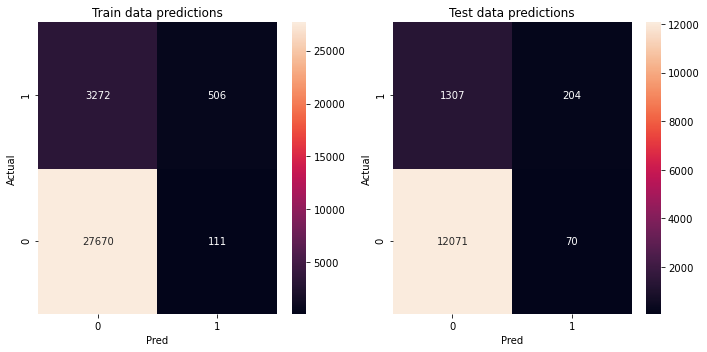

In [15]:
make_confusion_matrix_chart(train_cm, test_cm)

In [16]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        results_collect = rdd.collect()
        for row in results_collect:
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [17]:
def plot_roc_pr(df, target_variable_name, plot_type, legend_value, title):
    
    preds = df.select(target_variable_name,'probability')
    preds = preds.rdd.map(lambda row: (float(row['probability'][1]), float(row[target_variable_name])))
    # Returns as a list (false positive rate, true positive rate)
    points = CurveMetrics(preds).get_curve(plot_type)
    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title(title)
    
    if plot_type == 'roc':
        plt.xlabel('False Positive Rate (1-Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.plot(x_val, y_val, label = 'AUC = %0.2f' % legend_value)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    
    if plot_type == 'pr':
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.plot(x_val, y_val, label = 'Average Precision = %0.2f' % legend_value)
        plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--')
    
    plt.legend(loc = 'lower right')
    return None

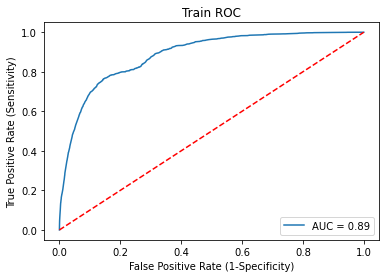

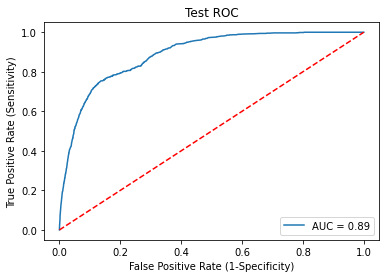

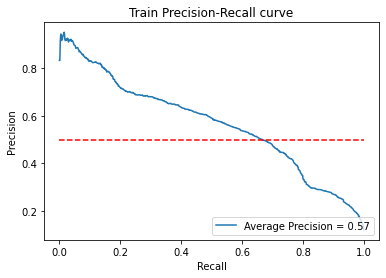

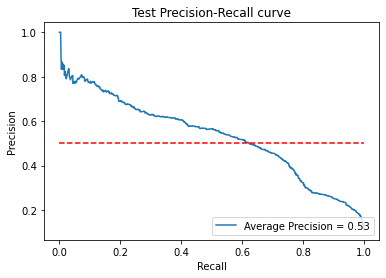

In [18]:
plot_roc_pr(train_pred_result, target_variable_name, 'roc', train_roc, 'Train ROC')
plot_roc_pr(test_pred_result, target_variable_name, 'roc', test_roc, 'Test ROC')
plot_roc_pr(train_pred_result, target_variable_name, 'pr', train_pr, 'Train Precision-Recall curve')
plot_roc_pr(test_pred_result, target_variable_name, 'pr', test_pr, 'Test Precision-Recall curve')